ASL, 17.06.22

# Introduction

> This notebook is based on the `brats_segmentation_3d.ipynb` notebook from https://github.com/Project-MONAI/tutorials. You should consult the MONAI documentation for a more thorough introduction to the MONAI framework: https://monai.io.

This notebook will give a hands-on example of deep learning in practice. Along the way, we will see some of the deep learning concepts covered in the introduction to the workshop translated into code. 

Our goal is to illustrate a possible approach to brain tumor segmentation, i.e., extracting meaningful tumor sub-regions. This can lead to important imaging biomarkers such as f.ex. volumes and locations, and also provide regions of interest for extracting _radiomics_ features. The next notebook will take a practical look at radiomics.

## The data: The Brain Tumor Segmentation (BraTS) challenge

We will use the data from the BraTS 2016 and 2017 competitions, consisting of 750 multi-parametric MRI studies of patients with brain tumors. Each study consists of four MRI modalities, T1w, contrast-enhanced T1w, T2w and FLAIR, and corresponding manual delineations of three tumor regions: necrotic tumor, active tumor and oedema.

![](assets/BRATS_tasks.png)

### Sample images

It is a heterogenous data set. Here are some sample images:

<img src="assets/brats-montage.png">

# Setup

As always when doing any kind of machine learning in Python, we start by importing various widely used Python libraries for general data analysis, plotting, data science, and machine learning, and set up the directories in which to store data:

## Set up Colab

> The first two code cells are to make sure the notebook can be executed in Google Colab:

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory, 
# as that makes some difference for the code below.
try:
    import colab
    colab=True
except:
    colab=False

In [2]:
if colab:
    !python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
    !python -c "import matplotlib" || pip install -q matplotlib
    !pip install fastcore

## Import basic Python libraries and set up folders

In [3]:
%matplotlib inline
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append("../")

In [4]:
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATA = Path("/content/gdrive/MyDrive/Colab Notebooks/data/brats")
    DATA.mkdir(exist_ok=True)
else:
    # Point this to where you want to store and unzip the file `stage1_train.zip'
    DATA = Path.home()/'data-tmp'/'brats'
    DATA.mkdir(exist_ok=True, parents=True)

In [5]:
import os
import shutil
import tempfile

from fastcore.utils import *

## Import deep learning libraries

MONAI is based on PyTorch. If you are familiar with PyTorch, you'll recognize parts of this notebook. You may consider having a look at the accompanying notebook introducing PyTorch. 

![](https://upload.wikimedia.org/wikipedia/commons/9/96/Pytorch_logo.png)

In [6]:
import torch

Here we import [MONAI](https://monai.io/)-specific functionality:

![](https://monai.io/assets/img/MONAI-logo_color_full.png)

In [7]:
from monai.config import print_config
from monai.utils import set_determinism

In [8]:
# Dealing with the data: downloading and loading into the ML pipeline
from monai.apps import DecathlonDataset
from monai.data import DataLoader

In [9]:
# Loss function and metric
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

In [10]:
# Network architecture
from monai.networks.nets import UNet

In [11]:
# Data augmentation
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
)

In [15]:
#print_config()

## What is data augmentation?

By doing **data augmentation** one aims to increase the diversity of a given data set by performing random, realistic transformations of the data. For images, these transformations can be rotations, flips, zooming, pixel intensity modifications, and much more. This also insures a degree of **invariance** to these transformations for the resulting trained models. 

There are many possible data augmentation techniques, ranging from basic to more advanced transformations, including techniques for combining multiple images into sets of "new" images (e.g., what's called "CutMix" or "MixUp" and more). 

Here's an illustration of some simple data augmentation strategies from https://www.quantib.com/blog/image-augmentation-how-to-overcome-small-radiology-datasets: 
![](https://www.quantib.com/hs-fs/hubfs/Blog%20and%20news%20images/Examples%20of%20rigid%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png?width=1549&name=Examples%20of%20rigid%20augmentation%20-%20AI%20in%20radiology%20-%20Quantib.png)

When doing data augmentation it is very important that 

- (i) the transformations won't change the correct label (f.ex., zooming in on a region of the image that doesn't contain the information needed to assign the class of the original image. Think zooming in on a part of a bone X-ray that doesn't contain the finding of interest, say, a fracture) 
- (ii) be at least somewhat realistic (f.ex., if you expect all the images to have a fixed up-down orientation, as is typically the case in, say, head MRI, vertical flips will not be a good idea). 

We'll use some transformations sourced from `monai.transforms` when training our model below. 

# Load data

We need to set up a dataloader to feed batches of data onto the GPU during training.

> PyTorch (and other deep learning frameworks) operate on what's called tensors, which are essentially multidimensional arrays that can be placed on GPUs for accellerated computing. To process the images we need to convert them to tensors. This will be done as the data is loaded.

In [16]:
path = DATA/'MONAI'
path.mkdir(exist_ok=True, parents=True)

In [17]:
batch_size = 4

In [18]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(np.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                np.logical_or(
                    np.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [19]:
train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=[128, 128, 64], random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 64]),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

Here we load and cache the dataset (cached for more efficient training later). This takes a while... To lower system memory requirements, set `cache_num` to a number less than 388. If you run out of GPU memory you may as usual try lowering the batch size.

In [20]:
train_ds = DecathlonDataset(
    root_dir=path,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    num_workers=4,
    #cache_num=100,
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)

Loading dataset: 100%|██████████| 388/388 [03:54<00:00,  1.65it/s]


In [21]:
val_ds = DecathlonDataset(
    root_dir=path,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)

Loading dataset: 100%|██████████| 96/96 [01:00<00:00,  1.60it/s]


# Take a look at some data

It's very important to inspect your data during development. Let's extract a sample from our training loader to verify that we get what we expect:

In [22]:
sample_data = next(enumerate(train_loader))

The MONAI data loaders have a specific structure:

In [23]:
sample_data[1].keys()

dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict', 'image_transforms', 'label_transforms'])

Per batch of 4 data points there are 4 images (T1, T1Gd, T2, FLAIR), each of the size (128, 128, 64) that we specified above:

In [24]:
sample_data[1]['image'].shape

torch.Size([4, 4, 128, 128, 64])

The same goes for the labels (i.e. the masks indicating the tumors):

In [25]:
sample_data[1]['label'].shape

torch.Size([4, 3, 128, 128, 64])

Additional image metadata is also available:

In [26]:
sample_data[1]['image_meta_dict']

{'sizeof_hdr': tensor([348, 348, 348, 348], dtype=torch.int32),
 'extents': tensor([0, 0, 0, 0], dtype=torch.int32),
 'session_error': tensor([0, 0, 0, 0], dtype=torch.int16),
 'dim_info': tensor([0, 0, 0, 0], dtype=torch.uint8),
 'dim': tensor([[  4, 240, 240, 155,   4,   1,   1,   1],
         [  4, 240, 240, 155,   4,   1,   1,   1],
         [  4, 240, 240, 155,   4,   1,   1,   1],
         [  4, 240, 240, 155,   4,   1,   1,   1]], dtype=torch.int16),
 'intent_p1': tensor([0., 0., 0., 0.]),
 'intent_p2': tensor([0., 0., 0., 0.]),
 'intent_p3': tensor([0., 0., 0., 0.]),
 'intent_code': tensor([0, 0, 0, 0], dtype=torch.int16),
 'datatype': tensor([16, 16, 16, 16], dtype=torch.int16),
 'bitpix': tensor([32, 32, 32, 32], dtype=torch.int16),
 'slice_start': tensor([0, 0, 0, 0], dtype=torch.int16),
 'pixdim': tensor([[1., 1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1., 1., 0., 0., 0.]]),
 'vox_

Here are a few images:

In [27]:
sample_data[1]['image'].shape

torch.Size([4, 4, 128, 128, 64])

In [28]:
# First data set in the batch:
ims = sample_data[1]['image'][0]
lbls = sample_data[1]['label'][0]

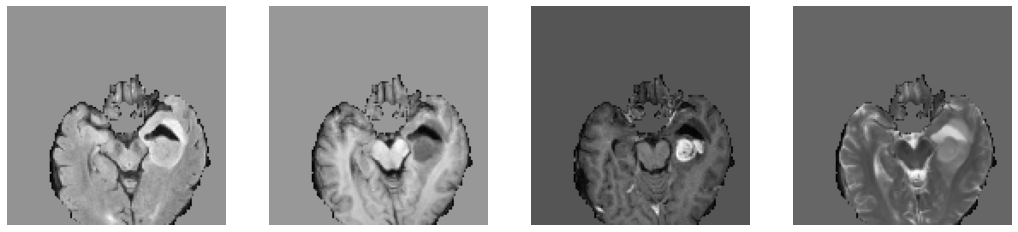

In [29]:
f, ax = plt.subplots(1,4, figsize=(18,6))
for i in range(4):
    ax[i].axis('off')
    ax[i].imshow(np.rot90(ims[i,:,:,32].detach().cpu()), cmap="gray")
plt.show()

Here are the labels overlayed on the first channel:

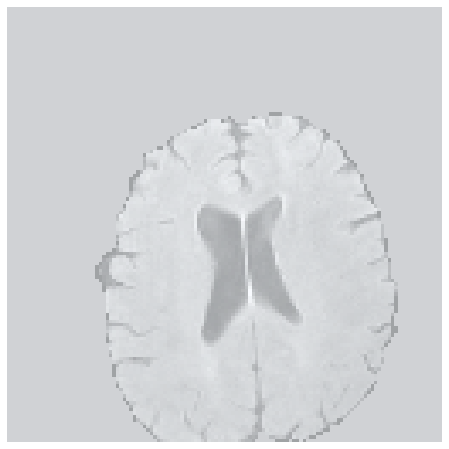

In [30]:
f = plt.figure(figsize=(8,8))

plt.imshow(np.rot90(ims[0,:,:,48].detach().cpu()), cmap="gray")

for i in range(3):
    plt.imshow(np.rot90(lbls[i,:,:,48].detach().cpu()), cmap='Blues', alpha=0.3)

plt.axis('off')
plt.show()

# Create a model

Now that we're able to fetch the data and prepare it for machine learning models, we need to set up the architecture of our artificial neural network. We'll use a version of the very famous and frequently used **UNet model** from Ronnenberger et.al., 2015 (https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).

In [31]:
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=4,
    out_channels=3,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    act='MISH'
).to(device)

In [32]:
import hiddenlayer as hl

ONNX export mode is set to inference mode, but operator dropout is set to training  mode. The model will be exported in inference, as specified by the export mode.


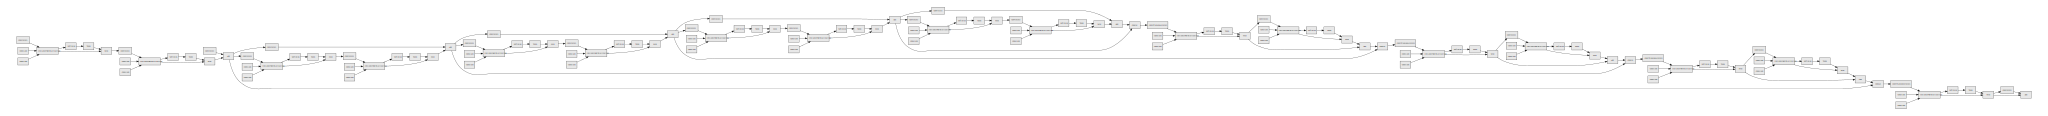

In [33]:
hl.build_graph(model, torch.zeros([4,4, 224, 224, 224]).cuda()).build_dot()

Here's a simplified illustration (from https://miro.medium.com/max/1400/1*x0kR2rGlTibVbu8InCNBVg.jpeg)

![](https://miro.medium.com/max/1400/1*x0kR2rGlTibVbu8InCNBVg.jpeg)

# Select a loss function and an optimizer

As loss function, we use the DiceLoss, which measures the amount of overlap between the segmentation proposed by the model and the ground truth segmentations:

In [35]:
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=True)

<img width=25% src="assets/dice.png">

After computing the loss and the gradients of the loss wrt. each parameter of our model, we need an **optimizer** to update the parameters. We'll use one of several versions of **gradient descent**. Specifically, we'll use the 2021 version the Ranger optimizer https://github.com/lessw2020/Ranger21:

In [36]:
import sys
!{sys.executable} -m pip install git+https://github.com/lessw2020/Ranger21.git

  Cloning https://github.com/lessw2020/Ranger21.git to /tmp/pip-req-build-c9dfspqp
  Running command git clone -q https://github.com/lessw2020/Ranger21.git /tmp/pip-req-build-c9dfspqp


In [38]:
from ranger21 import Ranger21

We decide on the number of epochs we'd like to train the model for. In other words, how many times we'll go through the training data. 

In [37]:
max_epochs = 200

In [39]:
optimizer = Ranger21(model.parameters(), lr=1e-3, num_epochs=max_epochs, 
                     num_batches_per_epoch=len(train_loader),
                    use_adaptive_gradient_clipping=False)

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 200 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = False

Warm-down: Linear warmdown, starting at 72.0%, iteration 13968 of 19400
warm down will decay until 3e-05 lr


# Training the model

As we discussed in the lecture, there are two main stages when training a neural network: a forward pass to get values for all the nodes between the input and output, and a backward pass where backpropagation (based on automatic differentiation and dynamic programming) and gradient descent is used to tweak all the parameters in the network.

To make gradient descent work, we need to be able to take the derivative of each component in the network (these derivatives are computed during backpropagation). Even if it's basically an application of the simple chain rule from calculus, it is a bit complicated to do efficiently. For details about these procedures, see http://cs231n.github.io/optimization-2.

Luckily PyTorch can take care of the differentiation for us (that is, the backward pass).

If you've done any kind of deep learning in PyTorch or TensorFlow, you'll recognize the following training loop. (If not, remember that you can watch the accompanying support video for an introduction to deep learning and PyTorch).

## The seven steps of training a neural network

There are seven steps to train a neural network:

1. Initialize the parameters.
2. Grab a batch of inputs and use the model with its current parameters to make predictions.
3. Based on these predictions, calculate how good the model is (its loss).
4. Calculate the gradients for each parameter using backpropagation. This measures how changing each parameter would change the loss
5. Step (that is, change) all the parameters based on that calculation.
6. Go back to the step 2, and repeat the process.
7. Iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer).

## Training loop

Warning: The model takes a long time to train (we will stop the training after a few epochs and not let it go all the way to the specified `max_epochs`. Feel free to train training for longer).. 

In [42]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if step%20 == 0:
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}"
                f", train_loss: {loss.item():.4f}"
            )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            dice_metric = DiceMetric(include_background=True, reduction="mean", 
                                    get_not_nans=True)
            post_trans = Compose(
                [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
            )
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = model(val_inputs)
                val_outputs = post_trans(val_outputs)
                # compute overall mean dice
                dm = dice_metric(y_pred=val_outputs, y=val_labels)
                value, not_nans = dice_metric.aggregate()
                not_nans = not_nans.item()
                metric_count += not_nans
                metric_sum += value.item() * not_nans
                

            metric = metric_sum / metric_count
            metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    os.path.join(path, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )

----------
epoch 1/200
params size saved
total param groups = 1
total params in groups = 46
20/97, train_loss: 0.9516
40/97, train_loss: 0.9366
60/97, train_loss: 0.9457
80/97, train_loss: 0.9561
epoch 1 average loss: 0.9513
----------
epoch 2/200
20/97, train_loss: 0.9563
40/97, train_loss: 0.9365
60/97, train_loss: 0.9563
80/97, train_loss: 0.9289
epoch 2 average loss: 0.9396


`threshold_values=True/False` is deprecated, please use `threshold=value` instead.


saved new best metric model
current epoch: 2 current mean dice: 0.0569
best mean dice: 0.0569 at epoch: 2
----------
epoch 3/200
20/97, train_loss: 0.9603
40/97, train_loss: 0.9599
60/97, train_loss: 0.9050
80/97, train_loss: 0.9380
epoch 3 average loss: 0.9314
----------
epoch 4/200
20/97, train_loss: 0.9317
40/97, train_loss: 0.9094
60/97, train_loss: 0.9282
80/97, train_loss: 0.9375
epoch 4 average loss: 0.9276
saved new best metric model
current epoch: 4 current mean dice: 0.1044
best mean dice: 0.1044 at epoch: 4
----------
epoch 5/200
20/97, train_loss: 0.9381
40/97, train_loss: 0.9630
60/97, train_loss: 0.9362
80/97, train_loss: 0.8960
epoch 5 average loss: 0.9249
----------
epoch 6/200
20/97, train_loss: 0.9545
40/97, train_loss: 0.8716
60/97, train_loss: 0.9132
80/97, train_loss: 0.8663
epoch 6 average loss: 0.9211
saved new best metric model
current epoch: 6 current mean dice: 0.1836
best mean dice: 0.1836 at epoch: 6
----------
epoch 7/200
20/97, train_loss: 0.8932
40/97, tr

Now we have a trained tumor segmentation model!

In [43]:
print(
    f"train completed, best_metric: {best_metric:.4f}"
    f" at epoch: {best_metric_epoch}"
)


train completed, best_metric: 0.7537 at epoch: 186


## Inspecting the training and validation loss and metric

Here are plots of the loss and dice metric observed during training:

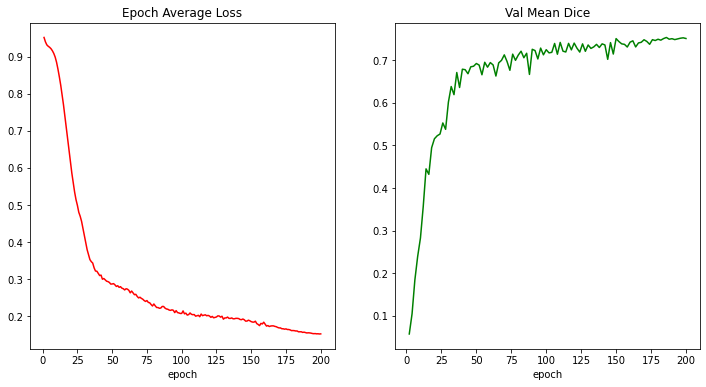

In [44]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

We note that the loss goes down while the dice score on the validation data increases. 

## Check some predictions

Here's a set of predictions for a few random validation data instances from the top performing model:

In [45]:
model.load_state_dict(
    torch.load(os.path.join(path, "best_metric_model.pth"))
)
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): Mish()
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): Mish()
          )
        )
      )
      (residual): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Con

In [46]:
import random

In [47]:
def plot_preds(ds):
    with torch.no_grad():
        # select one image to evaluate and visualize the model output
        val_input = val_ds[ds]["image"].unsqueeze(0).to(device)
        val_output = post_trans(model(val_input))
        plt.figure("image", (24, 6))
        for i in range(4):
            plt.subplot(1, 4, i + 1)
            plt.title(f"image channel {i}")
            plt.imshow(val_ds[ds]["image"][i, :, :, 20].detach().cpu(), cmap="gray")
        plt.show()
        # visualize the 3 channels label corresponding to this image
        plt.figure("label", (18, 6))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(f"label channel {i}")
            plt.imshow(val_ds[ds]["label"][i, :, :, 20].detach().cpu())
        plt.show()
        # visualize the 3 channels model output corresponding to this image
        plt.figure("output", (18, 6))
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(f"output channel {i}")
            plt.imshow(val_output[0, i, :, :, 20].detach().cpu())
        plt.show()

Example: BRATS_420.nii.gz



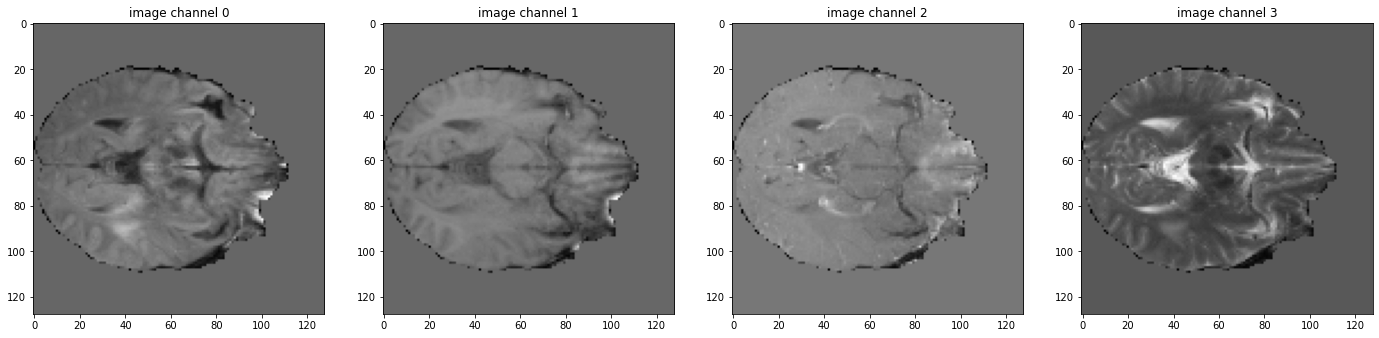

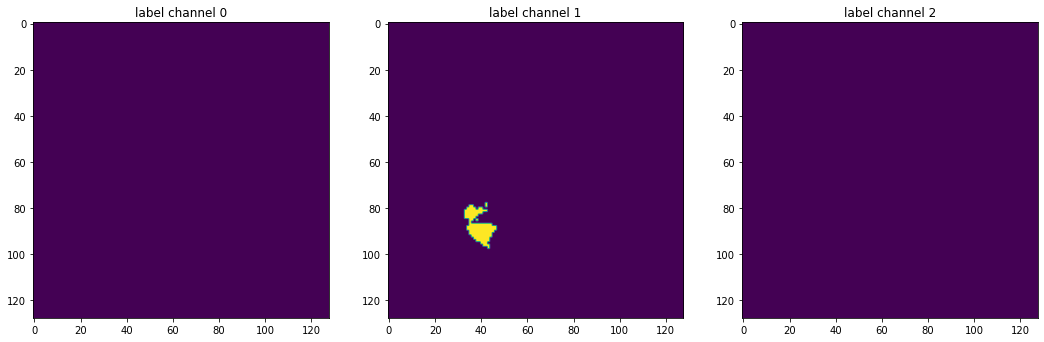

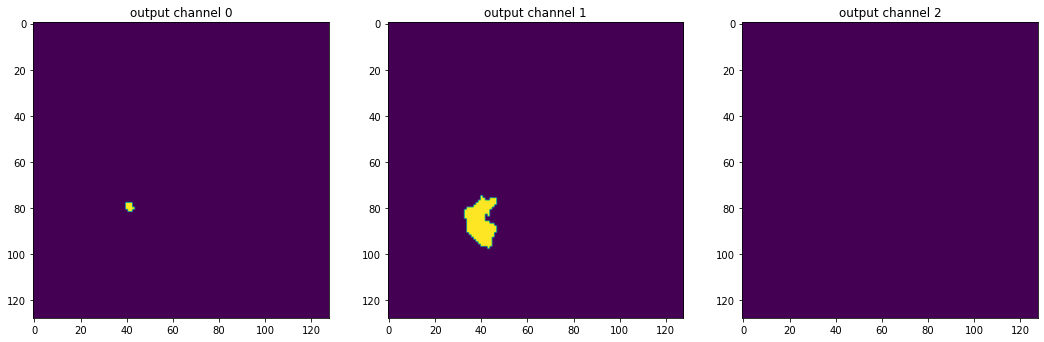

########################################
Example: BRATS_037.nii.gz



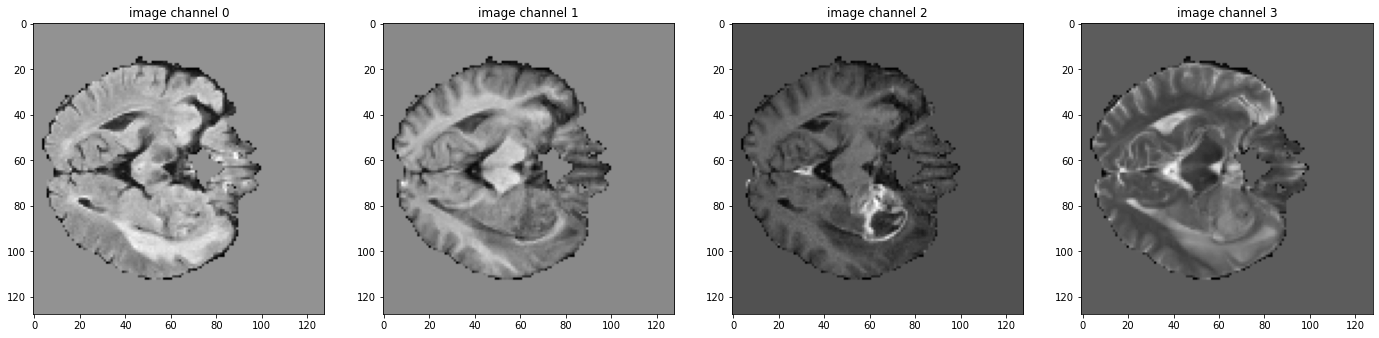

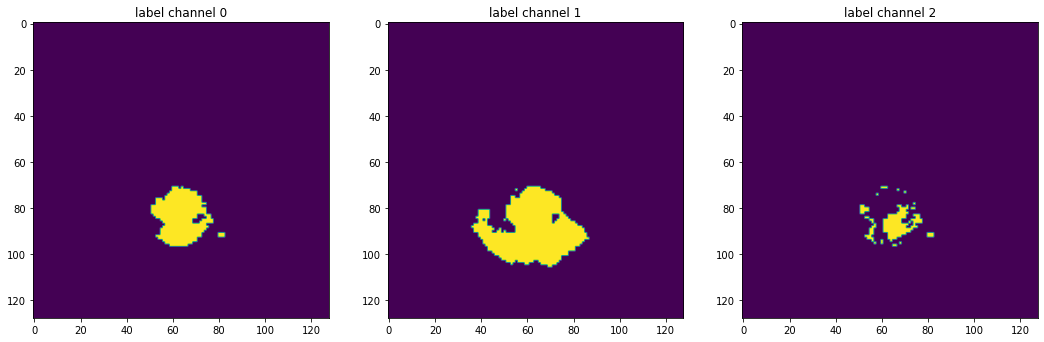

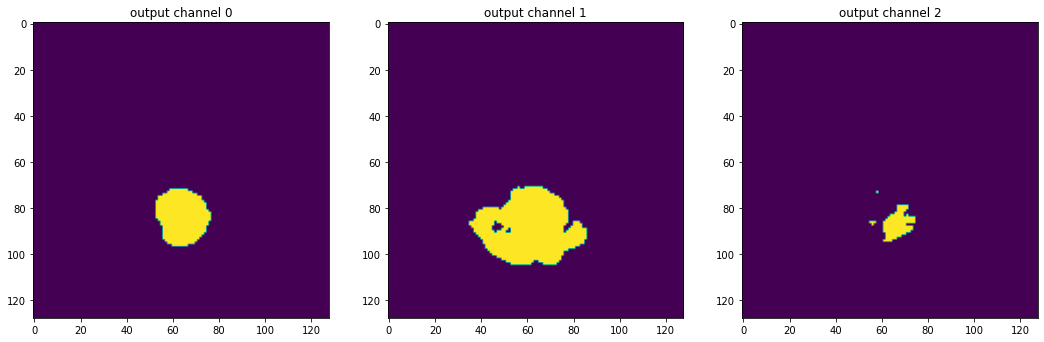

########################################
Example: BRATS_473.nii.gz



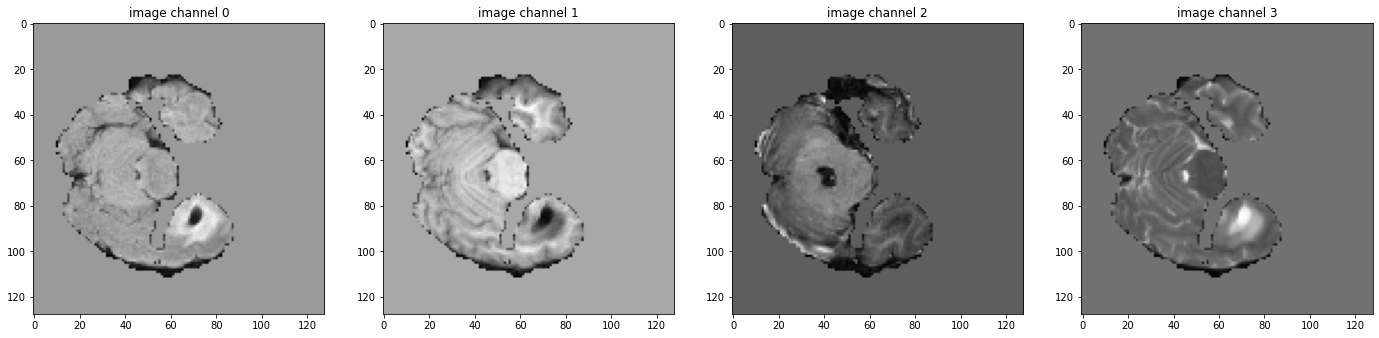

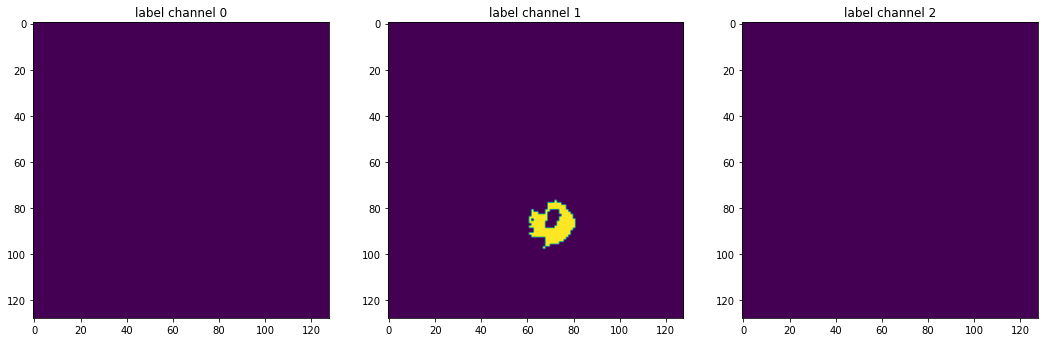

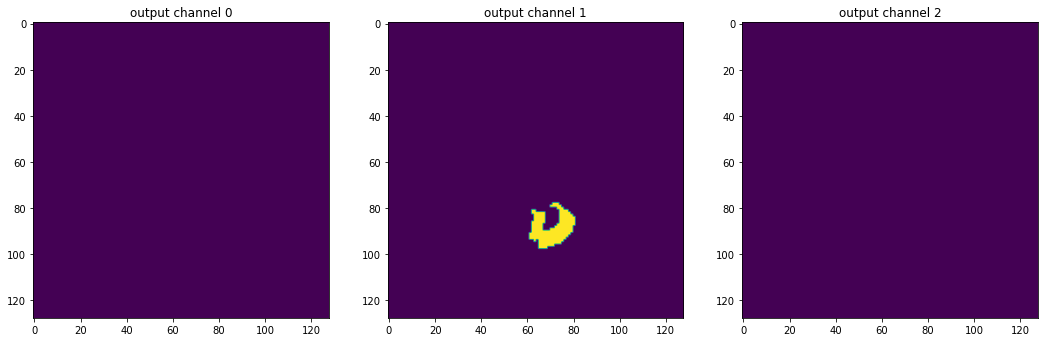

########################################
Example: BRATS_348.nii.gz



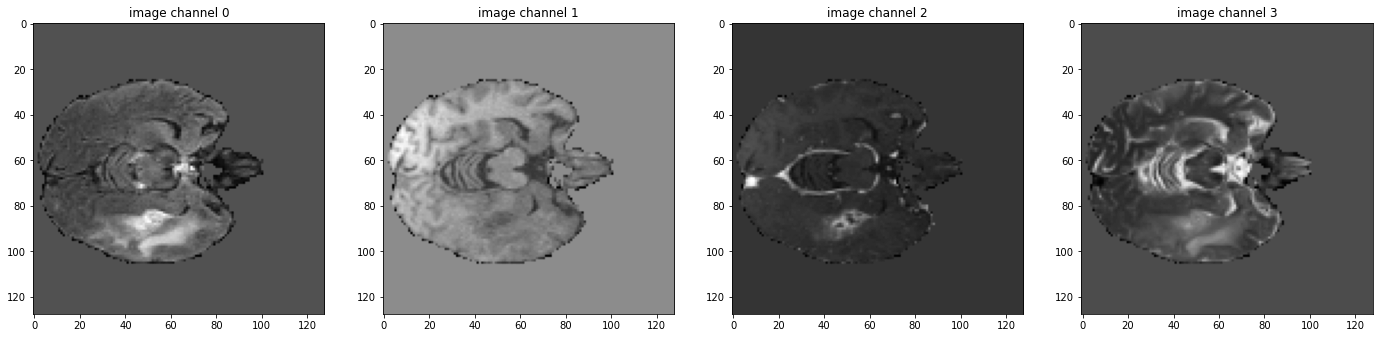

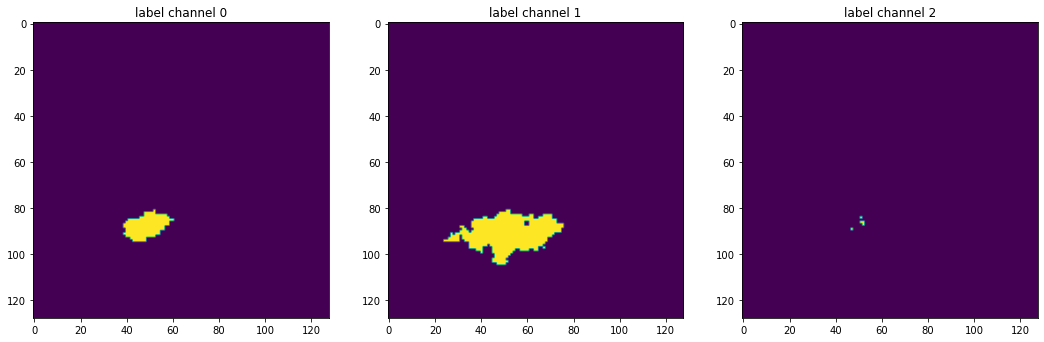

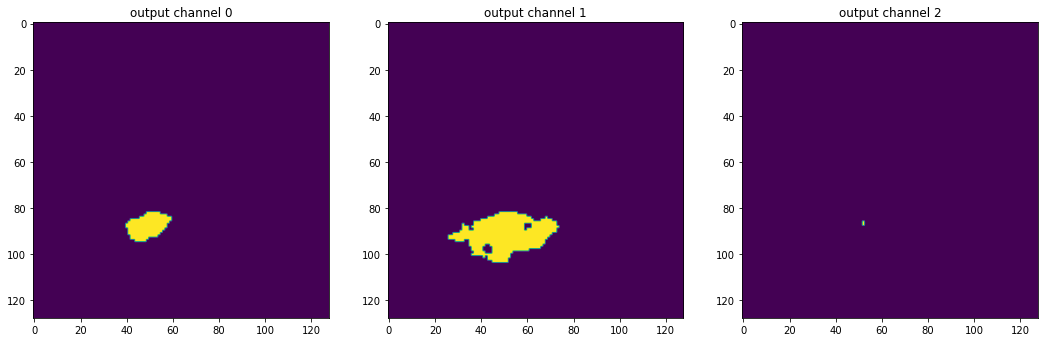

########################################


In [48]:
k=4
for ds in random.choices(range(len(val_ds)), k=k):
    fn = val_ds[ds]['image_meta_dict']['filename_or_obj'].split("/")[-1]
    print(f"Example: {fn}\n")
    plot_preds(ds)
    print("#"*40)

# Note

MONAI has a bunch of great features (https://monai.io), but there are other libraries that have implemented some neat tricks and approaches that are not part of MONAI. 

That's one reason why our PhD student [Sathiesh](https://skaliy.no/) is currently developing a library called **fastMONAI**, which combines features from MONAI with those available in another interesting library called [fastai](https://github.com/fastai/fastai):

<img src="assets/fastmonai.png">

fastMONAI has been used in the following papers, and is currently being used in multiple ongoing projects.
* [Fully Automatic Whole-Volume Tumor Segmentation in Cervical Cancer](https://www.mdpi.com/2072-6694/14/10/2372), Hodneland, E, Kaliyugarasan, S, et al., Cancers 14(10), 2022
* [Pulmonary nodule classification in lung cancer from 3D thoracic CT scans using fastai and MONAI](https://www.ijimai.org/journal/bibcite/reference/2944), S. Kaliyugarasan, A. Lundervold and A.S. Lundervold. IJIMAI, vol. 6, no. 7, 2021.
* [2D and 3D U-Nets for skull stripping in a large and heterogeneous set of head MRI using fastai](https://ojs.bibsys.no/index.php/NIK/article/view/836), Kaliyugarasan S, Kocinski M, Lundervold A, Lundervold AS., NIK2020, no.1, 2020.

<small>https://github.com/skaliy/fastMONAI/blob/master/nbs_dev/06a_multiclass_multimodal_segmentation.ipynb </small>

### TorchIO

As mentioned above, data augmentation is in general a good idea. Especially if you focus on **domain-specific data augmentation**. The library [TorchIO](https://torchio.readthedocs.io/) provides a set of augmentation techniques tailored for medical imaging. For a challenge, you can try to use the information in the notebook `extra-3-asl-data-augmentation_medical-imaging.ipynb` together with the above MONAI example to use additional data augmentation methods in the above setup. 

## Medical Segmentation Decathlon

There are more data sets in the Medical Segmentation Decathlon. See if you can construct a model for one of the other data sets.

# What's next?

Once you have extracted the tumor ROIs it's possible to quantify tumor size, shape and localization, as well as derive _radiomic_ features related to texture and the like. We'll look at this and more in the next notebook. 